# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение общей информации о данных

Подключим необходимые для выполнения проекта библиотеки

In [1]:
import pandas as pd #библиотека для работы с табличными типами данных
import numpy as np #библиотека для использования формул из математической статистики
import math #библиотека для использования более продвинутых математических функций
import matplotlib.pyplot as plt #библиотека для построения графиков
from scipy import stats as st #библиотека для использования статистических методов

Прочитаем файл "games.csv" и запишем данные в датафрейм *games*

In [2]:
games = pd.read_csv('/datasets/games.csv')

Выведем первые строчки датасета на экран

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Посмотрим информацию о наборе данных

In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
games.duplicated().sum()

0

Вывод: данные извлечены правильно, дубликаты не найдены, но, как мы видим, в таблице почти в каждом столбце есть пропуски, которые необходимо обработать, прежде чем приступать к анализу данных

## Подготовка данных

Для того, чтобы получить приемлимый и не "шумный" результат на выходе, нам нужно обработать данные на входе, чтобы в данных не было случайных пропусков, чтобы они имели правильный тип данных, и чтобы у нас была вся нужная для дальнейшего анализа информация об объектах исследования(играх)

### Замена названий столбцов

Для начала исправим названия всех колонок на строчные - это правило хорошего тона

In [6]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков

Узнаем, в каких столбцах есть пропуски

In [7]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Рассмотрим строчки с пропусками подробнее

In [8]:
games[games['name'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [9]:
games[games['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


In [10]:
games[games['genre'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Как мы видим, строчки с пропусками в столбце *name* и в столбце *genre* одни и те же, и они абсолютно не информативны для нас. Их мы удалим

In [11]:
games = games.dropna(subset=['name', 'genre'])
games.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

In [12]:
names_before = games[games['year_of_release'].isna()]['name'].tolist() #создадим список с названиями игр, в которых были
                                                                    #пропущены значения

Пропуски в столбце *год выхода* можно заполнить годом появления игры на другой платформе (чаще всего это один и тот же год или очень близкое значение)

In [13]:
year_of_release_by_name = games.pivot_table(index='name', values='year_of_release', aggfunc='median').rename(columns={
    'year_of_release':'year_of_release_median'
})
year_of_release_by_name.head()

,year_of_release_median
name,
Beyblade Burst,2016.0
Fire Emblem Fates,2015.0
Frozen: Olaf's Quest,2013.0
Haikyu!! Cross Team Match!,2016.0
Tales of Xillia 2,2012.0


In [14]:
games = games.merge(year_of_release_by_name, on='name', how='left')
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_of_release_median
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,2006.0
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,1992.0
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,2008.0
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,2009.0
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,1996.0


In [15]:
games['year_of_release'] = games['year_of_release'].fillna(games['year_of_release_median'])
print('Пропусков после замены:', games['year_of_release'].isna().sum())

Пропусков после замены: 146


Оставшиеся пропущенные значения заполним с помощью года, указанного в названии игры (если в названии он каким-то образом фигурирует). Для разных игр это будет разное значение: например, для большинства спортивных игр значение будет равно указанному году минус один, а для игр, где просто указан год (обычно в скобках) - вставим его как есть

In [16]:
def findYoRInName(row): #функция замены года выхода игры в соответствии с годом, указанным в названии
    if math.isnan(row['year_of_release']):
        for year in range(int(games['year_of_release'].min()), int(games['year_of_release'].max()+1)):
            if str(year) in row['name']:
                if '(' + str(year) + ')' in row['name']:
                    return year
                else:
                    return year-1
            else:
                for year00 in range(2000, 2010):
                    if ' 0'+str(year00-2000) in row['name']:
                        return year00-1
                    #elif 
                    elif ' 2K' in row['name'] or ' 2k' in row['name']:
                        for kyear in range(2001, int(games['year_of_release'].max()+1)):
                            if ' 2K'+str(kyear-2000) in row['name'] or ' 2k'+str(kyear-2000) in row['name']:
                                return kyear-1
                        else:
                            return 1999
    else:
        return row['year_of_release']

In [17]:
games['year_of_release'] = games.apply(findYoRInName, axis=1)
print('Пропусков после замены:', games['year_of_release'].isna().sum())

Пропусков после замены: 139


Посмотрим на то, как мы заполнили пропуски в столбце *год выпуска* и какие пропуски еще остались:

In [18]:
for name in names_before:
        print('{0}\n{1}\n'.format(name, games[games['name']==name]['year_of_release']))

Madden NFL 2004
183     2003.0
1880    2003.0
3888    2003.0
5707    2003.0
Name: year_of_release, dtype: float64

FIFA Soccer 2004
377      2003.0
2605     2003.0
12028    2003.0
13085    2003.0
Name: year_of_release, dtype: float64

LEGO Batman: The Videogame
397      2008.0
456      2008.0
460      2008.0
1518     2008.0
1537     2008.0
1552     2008.0
12464    2008.0
Name: year_of_release, dtype: float64

wwe Smackdown vs. Raw 2006
475    2005.0
Name: year_of_release, dtype: float64

Space Invaders
609      1999.0
4263     1994.0
8579     1999.0
10382    2002.0
Name: year_of_release, dtype: float64

Rock Band
627    NaN
804    NaN
1141   NaN
1839   NaN
Name: year_of_release, dtype: float64

Frogger's Adventures: Temple of the Frog
657   NaN
Name: year_of_release, dtype: float64

LEGO Indiana Jones: The Original Adventures
329      2008.0
677      2008.0
742      2008.0
1407     2008.0
1722     2008.0
2012     2008.0
13713    2008.0
Name: year_of_release, dtype: float64

Call of Dut

Как мы видим, заполненные пропуски зачастую совпадают с годом, в котором вышла эта же игра на большинстве других устройств. Однако есть исключения: игры, у которых не указана дата - это могут быть как игры для определенных консолей, так и многоплатформенные. Конечно, и эти пропуски можно заполнить, поискав информацию в Интернете. Однако это отнимет много времени, а потеря 139 строчек в масштабе 16 тысяч - невеликая потеря - поэтому удалим их

In [19]:
games = games.dropna(subset=['year_of_release'])
games = games.drop('year_of_release_median', 1)
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8495
user_score         6636
rating             6703
dtype: int64

Возрастной рейтинг игры заполним также: найдем рейтинг этой игры, который будет указан для этой игры только на другой платформе (обычно эти значения не отличаются для версий на разных устройствах)

In [20]:
rating_by_name = games.query('rating.isna() == False').pivot_table(index='name', values='rating', aggfunc='first').\
rename(columns={'rating':'rating_by_name'})
display(rating_by_name.info(), rating_by_name.head())

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries,  Tales of Xillia 2 to uDraw Studio: Instant Artist
Data columns (total 1 columns):
rating_by_name    6000 non-null object
dtypes: object(1)
memory usage: 93.8+ KB


None

,rating_by_name
name,
Tales of Xillia 2,T
.hack//Infection Part 1,T
.hack//Mutation Part 2,T
.hack//Outbreak Part 3,T
007 Racing,T


In [21]:
games = games.merge(rating_by_name, on='name', how='left')

In [22]:
games['rating'] = games['rating'].fillna(games['rating_by_name'])
games = games.drop('rating_by_name', 1)
print('Пропусков после замены:', games['rating'].isna().sum())

Пропусков после замены: 6266


В данном случае у нас осталось слишком много пропусков, чтобы просто избавиться от этих строчек (в случае удаления мы потеряем весомую часть данных). Поэтому заполним пропуски значением *unknown*

In [23]:
games['rating'] = games['rating'].fillna('unknown')
print('Пропусков после замены:', games['rating'].isna().sum())

Пропусков после замены: 0


In [24]:
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8495
user_score         6636
rating                0
dtype: int64

С пропусками остались только столбцы с оценками критиков и пользователей. Данный пропуски невозможно корректно восстановить (не вручную), а если заполнить характерными значениями по выборке или нулями, то результат сильно исказиться. Поэтому предпочтем оставить численные значения и *NaN*

P.s. значения *tbd* *("подлежит уточнению")* в столбце *user_score* также заменим на *NaN* для упрощения дальнейшего взаимодействия с таблицей

In [25]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan

In [26]:
games.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8495
user_score         9031
rating                0
dtype: int64

### Преобразование типов данных

Вспомним, какие типы данных содержатся в той или иной колонке

In [27]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16574 entries, 0 to 16573
Data columns (total 11 columns):
name               16574 non-null object
platform           16574 non-null object
year_of_release    16574 non-null float64
genre              16574 non-null object
na_sales           16574 non-null float64
eu_sales           16574 non-null float64
jp_sales           16574 non-null float64
other_sales        16574 non-null float64
critic_score       8079 non-null float64
user_score         7543 non-null object
rating             16574 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Теперь перейдем к преобразованию типов данных

In [28]:
games['year_of_release'] = games['year_of_release'].astype('uint16') #диапазон значений uint16 - [0, 65535]

games['na_sales'] = games['na_sales'].astype('float16') #диапазон значений float16 - [0.0, 65500.0]
games['eu_sales'] = games['eu_sales'].astype('float16')
games['jp_sales'] = games['jp_sales'].astype('float16')
games['other_sales'] = games['other_sales'].astype('float16')

games['critic_score'] = games['critic_score'].astype('float16')
games['user_score'] = games['user_score'].astype('float16')

In [29]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16574 entries, 0 to 16573
Data columns (total 11 columns):
name               16574 non-null object
platform           16574 non-null object
year_of_release    16574 non-null uint16
genre              16574 non-null object
na_sales           16574 non-null float16
eu_sales           16574 non-null float16
jp_sales           16574 non-null float16
other_sales        16574 non-null float16
critic_score       8079 non-null float16
user_score         7543 non-null float16
rating             16574 non-null object
dtypes: float16(6), object(4), uint16(1)
memory usage: 874.0+ KB


Затраты по памяти сокращены почти вдвое

### Добавление дополнительного показателя *суммарные продажи*

Добавим к таблице еще один столбец *суммарные продажи* - продажи по всем регионам

In [30]:
games['world_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games[['name', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'world_sales']].head()

,name,na_sales,eu_sales,jp_sales,other_sales,world_sales
0,Wii Sports,41.375000,28.953125,3.769531,8.453125,82.500
1,Super Mario Bros.,29.078125,3.580078,6.808594,0.770020,40.250
2,Mario Kart Wii,15.679688,12.757812,3.789062,3.289062,35.500
3,Wii Sports Resort,15.609375,10.929688,3.279297,2.949219,32.750
4,Pokemon Red/Pokemon Blue,11.273438,8.890625,10.218750,1.000000,31.375


Вывод: по итогам предобработки данных мы очистили данные от пропусков, от которых могли очистить. Пропуски, приходящиеся на столбцы с оценками критиков и пользователей, мы не можем не заполнить (так как пропуски неслучайные в данном контексте), не удалить (так как потеряем больше половины от всех данных). Данные пропуски мы оставили значениями *NaN*, а влияние этих столбцов на другие характеристики теперь будем рассматривать в меньшей степени. Также в меньшей степени будем смотреть на влияние столбца *rating*, так как большую часть его значений мы заполнили значениями по умолчанию - *unknown*. Остальным пропускам (в *годах выпуска* и в *жанрах*), в основном, присвоили аналогичные значения этой же игры для другой платформы. В завершении обработки начальной таблицы мы преобразовали типы данных почти во всех столбцах без потери в качестве, но с экономией по ресурсам почти в два раза.

Вот так сейчас выглядит таблица с данными

In [31]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,Wii Sports,Wii,2006,Sports,41.375000,28.953125,3.769531,8.453125,76.0,8.000000,E,82.500
1,Super Mario Bros.,NES,1985,Platform,29.078125,3.580078,6.808594,0.770020,NaN,NaN,unknown,40.250
2,Mario Kart Wii,Wii,2008,Racing,15.679688,12.757812,3.789062,3.289062,82.0,8.296875,E,35.500
3,Wii Sports Resort,Wii,2009,Sports,15.609375,10.929688,3.279297,2.949219,80.0,8.000000,E,32.750
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.273438,8.890625,10.218750,1.000000,NaN,NaN,unknown,31.375


Вот так ее краткие характеристики

In [32]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16574 entries, 0 to 16573
Data columns (total 12 columns):
name               16574 non-null object
platform           16574 non-null object
year_of_release    16574 non-null uint16
genre              16574 non-null object
na_sales           16574 non-null float16
eu_sales           16574 non-null float16
jp_sales           16574 non-null float16
other_sales        16574 non-null float16
critic_score       8079 non-null float16
user_score         7543 non-null float16
rating             16574 non-null object
world_sales        16574 non-null float16
dtypes: float16(7), object(4), uint16(1)
memory usage: 906.4+ KB


## Анализ данных

### Тенденции в индустрии игр

Для начала интересно посмотреть на то, как со временем менялось количество выпускаемых игр в год

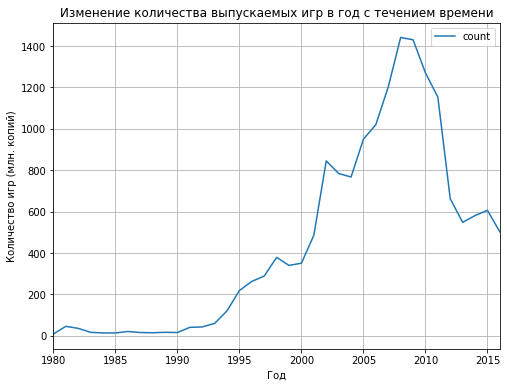

In [33]:
(games
.pivot_table(index='year_of_release', values='name', aggfunc='count')
.rename(columns={'name':'count'})
.plot(grid=True, figsize=(8,6))
)
plt.xlabel('Год')
plt.ylabel('Количество игр (млн. копий)')
plt.title('Изменение количества выпускаемых игр в год с течением времени')
plt.show()

In [34]:
#plt.figure(figsize=(8,6))
#plt.grid(True)
#plt.hist(games['year_of_release'], bins=37)
#plt.show()

Интуитивно ожидалось что-то подобное - значительное увеличение количества выпускаемых игр с течением времени. Однако удивительна тенденция на уменьшение выпуска игр - она началась в конце нулевых и продолжалась до конца исследуемого периода.

Также немаловажным является тот факт, что до определенного года игр выходило несопоставимо меньше, чем в современную эпоху

In [35]:
games['year_of_release'].describe()

count    16574.000000
mean      2006.489683
std          5.861696
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

В период с 2003-го по 2007-й на свет появилось столько же игр, сколько с 1980-го по 2003-й. В среднем, почти в 8 раз в год меньше игр

Может быть такой резкий скачок производства игр связан с появлением новых платформ? Давайте рассмотрим это предположение.

Для начала выберем 5 платформ с наибольшими суммарными продажами за весь исследуемый период

In [36]:
(games
 .pivot_table(index='platform', values='world_sales', aggfunc='sum')
 .sort_values(by='world_sales', ascending=False)
 .head()
)

,world_sales
platform,
PS2,1251.0
X360,966.5
PS3,935.0
Wii,903.0
DS,804.5


In [37]:
ps2 = (games
       .query('platform == "PS2"')
       .pivot_table(index='year_of_release', values='world_sales', aggfunc='sum')
      )

x360 = (games
        .query('platform == "X360"')
        .pivot_table(index='year_of_release', values='world_sales', aggfunc='sum')
       )

ps3 = (games
       .query('platform == "PS3"')
       .pivot_table(index='year_of_release', values='world_sales', aggfunc='sum')
      )

wii = (games
       .query('platform == "Wii"')
       .pivot_table(index='year_of_release', values='world_sales', aggfunc='sum')
      )

ds = (games
      .query('platform == "DS"')
      .pivot_table(index='year_of_release', values='world_sales', aggfunc='sum')
     )

#ps = (games.query('platform == "PS"').pivot_table(index='year_of_release', values='world_sales'))

Теперь построим график изменения продаж игр от времени для этих платформ (будем рассматривать период с 2000-го года)

In [38]:
top5_platforms = (ds
                  .join(ps2, on='year_of_release', how='outer', lsuffix='_ds')
                  .join(x360, on='year_of_release', how='outer', lsuffix='_ps2')
                  .join(ps3, on='year_of_release', lsuffix='_x360')
                  .join(wii, on='year_of_release', lsuffix='_ps3', rsuffix='_wii')
                  .fillna(0)
                 )
top5_platforms.index = top5_platforms['year_of_release']
top5_platforms = top5_platforms.sort_index()
top5_platforms.head(10)

,year_of_release,world_sales_ds,world_sales_ps2,world_sales_x360,world_sales_ps3,world_sales_wii
year_of_release,,,,,,
1985,1985,0.020004,0.00000,0.00000,0.000000,0.000
2000,2000,0.000000,39.15625,0.00000,0.000000,0.000
2001,2001,0.000000,166.37500,0.00000,0.000000,0.000
2002,2002,0.000000,208.75000,0.00000,0.000000,0.000
2003,2003,0.000000,193.00000,0.00000,0.000000,0.000
2004,2004,17.265625,213.12500,0.00000,0.000000,0.000
2005,2005,130.125000,164.00000,9.21875,0.190063,0.000
2006,2006,119.812500,104.00000,51.81250,21.437500,140.125
2007,2007,147.250000,76.12500,95.37500,73.187500,153.375


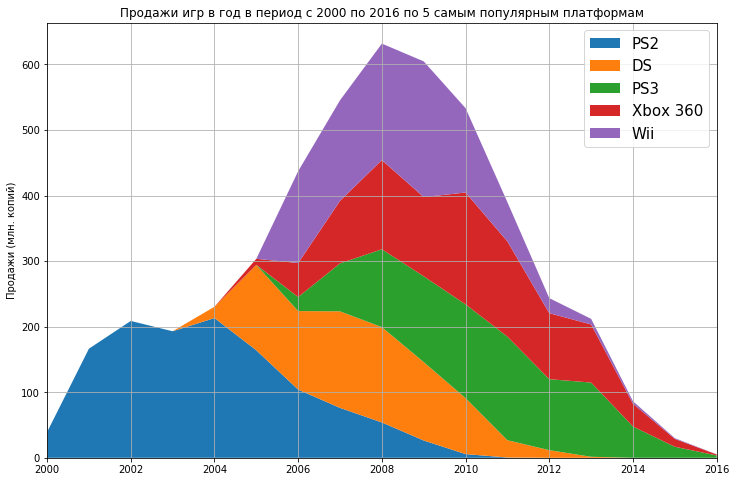

In [39]:
plt.figure(figsize=(12,8))
plt.grid(True)
labels=['PS2', 'DS', 'PS3', 'Xbox 360', 'Wii']
ax = plt.stackplot(top5_platforms.index, top5_platforms['world_sales_ps2'],
                   top5_platforms['world_sales_ds'], top5_platforms['world_sales_ps3'],
                   top5_platforms['world_sales_x360'], top5_platforms['world_sales_wii'], labels=labels)
plt.xlim(2000, 2016)
plt.legend(fontsize=15)
plt.ylabel('Продажи (млн. копий)')
plt.title('Продажи игр в год в период с 2000 по 2016 по 5 самым популярным платформам')
plt.show()

Как мы видим, резкое увеличение числа выпускаемых игр в период с 2008-2009 годов связано с тем, что в тот момент на пик своей популярности выходили такие платформы как Wii, PS3 и Xbox 360. Видимо, конкуренция и вынудила выпускать больше игр.

Также взглянув на график, можно сказать и о том, что характерный срок актуальности платформы составляет 6-7 лет, так что возьмем данные, начиная с 2011-го и в дальнейшем будем работать с ними

In [40]:
games_actual = games.query('year_of_release >= 2011')

### Актуальные платформы

С учетом вышесказанного давайте рассмотрим последний актуальный период (2011-2016 гг.). По нему мы найдем самые популярные платформы и попробуем выделить наиболее перспективные на ближайший год

In [41]:
(games_actual
 .pivot_table(index='platform', values='world_sales', aggfunc='sum')
 .sort_values(by='world_sales', ascending=False)
 .head()
)

,world_sales
platform,
PS3,447.75
X360,382.75
PS4,314.25
3DS,258.25
XOne,159.25


In [42]:
ps4 = (games_actual
       .query('platform == "PS4"')
       .pivot_table(index='year_of_release', values='world_sales', aggfunc='sum')
       )

ds3 = (games_actual
       .query('platform == "3DS"')
       .pivot_table(index='year_of_release', values='world_sales', aggfunc='sum')
       )

xone = (games_actual
        .query('platform == "XOne"')
        .pivot_table(index='year_of_release', values='world_sales', aggfunc='sum')
        )

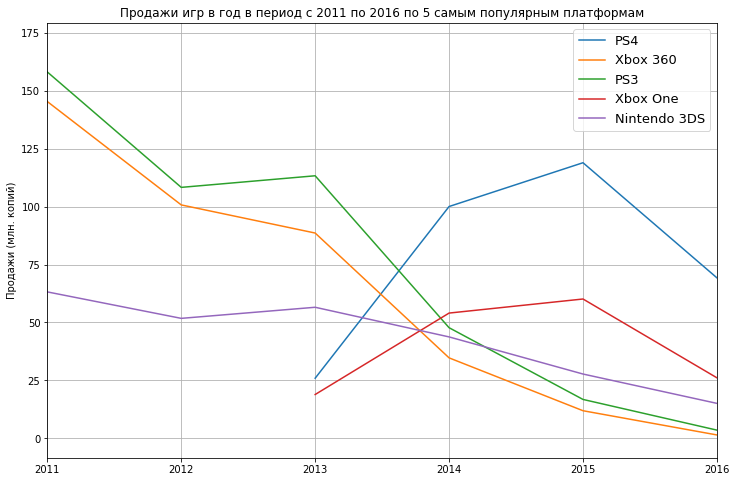

In [43]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(ps4, label='PS4')
ax.plot(x360, label='Xbox 360')
ax.plot(ps3, label='PS3')
ax.plot(xone, label='Xbox One')
ax.plot(ds3, label='Nintendo 3DS')

ax.set_xlim(2011, 2016)
ax.legend(fontsize=13)
ax.set_title('Продажи игр в год в период с 2011 по 2016 по 5 самым популярным платформам')
ax.set_ylabel('Продажи (млн. копий)')
plt.grid(True)
plt.show()

Перспектива у большинства платформ удручающая. Продажи игр на все самые популярные устройства в последние годы падают. Лучше всех на фоне конкурентов выглядит PS4: он лидирует в индустрии и продажи начали падать только в 2016-м году. На 2017-й год это самая перспективная платформа. На втором месте расположился Xbox One. В абсолюте показатели продаж за 2016-й год более чем в 2 раза меньше, чем у конкурента, однако относительно себя прошлогоднего продажи упали чуть менее круто, чем у PS4

In [44]:
top5_platforms_since_2011 = (games_actual
                             .query('platform in ["PS4", "XOne", "PS3", "X360", "3DS"]')
                             .pivot_table(index=['year_of_release', 'platform'], values='world_sales', aggfunc='sum')
                             .reset_index()
                            )
top5_platforms_since_2011.head()

,year_of_release,platform,world_sales
0,2011,3DS,63.18750
1,2011,PS3,158.00000
2,2011,X360,145.25000
3,2012,3DS,51.78125
4,2012,PS3,108.25000


Рассмотрим распределение продаж игр по разным платформам в год за этот же период

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


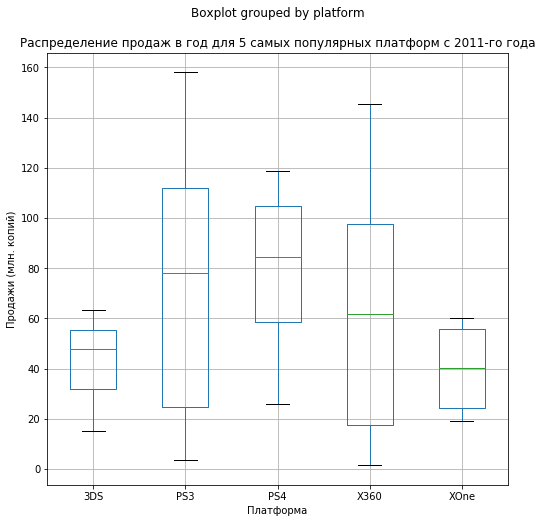

In [45]:
top5_platforms_since_2011[['platform', 'world_sales']].boxplot(by='platform', grid=True, figsize=(8,8))
plt.title('Распределение продаж в год для 5 самых популярных платформ с 2011-го года')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн. копий)')
plt.show()

Как мы видим, лучше всех по средним продажам в год является также PS4, ненамного опередив предшественника PS3. Про конкурента можно сказать противоположное: последняя версия платформы менее популярна у пользователей, чем предшественник в лице Xbox 360, однако продажи весьма предсказуемы и варьируются то 20 до 60 миллионов в год (наименьший разброc из топ-5)

### Влияние оценок критиков и пользователей

Теперь рассмотрим, насколько мировые продажи той или иной игры кореллируют с отзывами критиков и пользователей

Чтобы игры не повторялись и исследование зависимости было более точное, возьмем для рассмотрения одну платформу, игры на которые имеют наибольшее количество оценок за последний актуальный период

In [46]:
print('Количество оценок критиков по платформам:\n{0}\n\nКоличество оценок пользователей по платформам:\n{1}'.
      format(games_actual[games_actual['critic_score'].isna() == False]['platform'].value_counts().head(),
             games_actual[games_actual['user_score'].isna() == False]['platform'].value_counts().head()))

Количество оценок критиков по платформам:
PS3     352
X360    299
PC      296
PS4     252
XOne    169
Name: platform, dtype: int64

Количество оценок пользователей по платформам:
PS3     419
X360    368
PC      314
PS4     257
XOne    182
Name: platform, dtype: int64


Как у критиков, так и у пользователей наибольшой популярностью пользовалась PS3. В качестве примера рассмотрим именно эту платфому

In [47]:
world_sales_ps3_by_score = games_actual.query('platform == "PS3"')[['world_sales', 'critic_score', 'user_score']]
world_sales_ps3_by_score.head()

,world_sales,critic_score,user_score
16,21.062500,97.0,8.203125
34,13.789062,83.0,5.300781
37,13.328125,88.0,3.199219
69,9.367188,71.0,2.599609
81,8.171875,88.0,6.601562


Построим диаграммы рассеяния мировых продаж от оценок

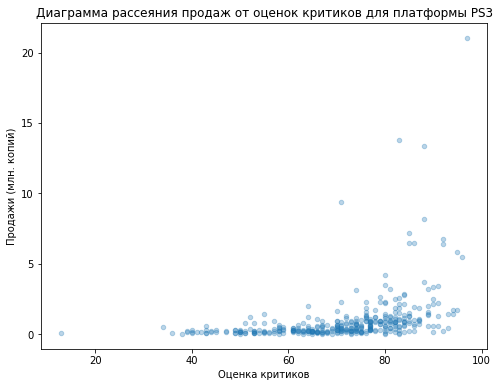

In [48]:
world_sales_ps3_by_score.plot(x='critic_score', y='world_sales', kind='scatter', figsize=(8,6), alpha=0.3)
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи (млн. копий)')
plt.title('Диаграмма рассеяния продаж от оценок критиков для платформы PS3')
plt.show()

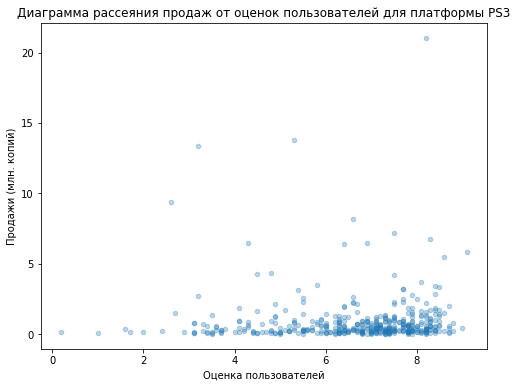

In [49]:
world_sales_ps3_by_score.plot(x='user_score', y='world_sales', kind='scatter', figsize=(8,6), alpha=0.3)
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи (млн. копий)')
plt.title('Диаграмма рассеяния продаж от оценок пользователей для платформы PS3')
plt.show()

Как можно судить по графикам: прямая зависимость не наблюдается, однако самые продаваемые игры непременно получают хорошие оценки у критиков. А вот пользовательские оценки в меньшей степени влияют на продажи игры

In [50]:
print('Матрица корреляций между продажами, оценками критиков и пользователей для платформы PS3')
display(world_sales_ps3_by_score.corr())

Матрица корреляций между продажами, оценками критиков и пользователей для платформы PS3


,world_sales,critic_score,user_score
world_sales,1.000000,0.380242,0.014053
critic_score,0.380242,1.000000,0.562711
user_score,0.014053,0.562711,1.000000


Матрица корреляции подтверждает наши слова: прямой зависимости ни от оценок пользователей, ни от оценок критиков у продаж нет.

Исследуем ту же самую зависимость в разрезе оставшихся платформ

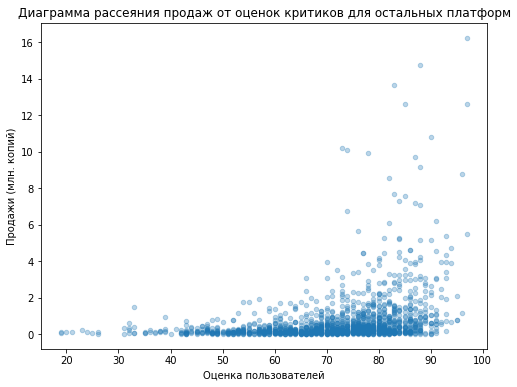

In [51]:
(
    games_actual
    .query('platform != "PS3"')
    .plot(x='critic_score', y='world_sales', kind='scatter', figsize=(8,6), alpha=0.3)
)
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи (млн. копий)')
plt.title('Диаграмма рассеяния продаж от оценок критиков для остальных платформ')
plt.show()

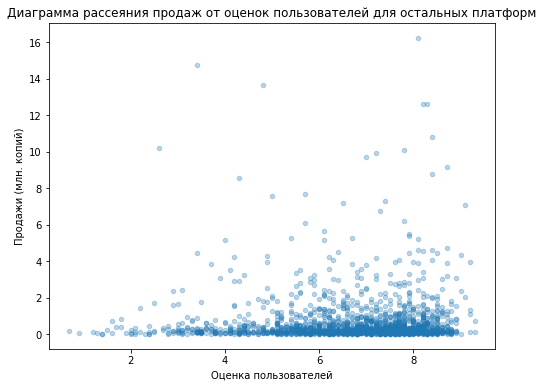

In [52]:
(
    games_actual
    .query('platform != "PS3"')
    .plot(x='user_score', y='world_sales', kind='scatter', figsize=(8,6), alpha=0.3)
)
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи (млн. копий)')
plt.title('Диаграмма рассеяния продаж от оценок пользователей для остальных платформ')
plt.show()

In [53]:
print('Матрица корреляций между продажами, оценками критиков и пользователей для других платформ')
display(games_actual.query('platform != "PS3"')[['world_sales', 'critic_score', 'user_score']].corr())

Матрица корреляций между продажами, оценками критиков и пользователей для других платформ


,world_sales,critic_score,user_score
world_sales,1.000000,0.317096,0.038642
critic_score,0.317096,1.000000,0.528187
user_score,0.038642,0.528187,1.000000


Как мы видим, результаты получились очень схожими, что позволяет нам сделать вывод о том, что сильной прямой зависимости ни от оценок критиков, ни от оценок пользователей у продаж нет. Однако чтобы игра стала культовой и разошлась многомиллионным тиражом, необходимо получить высокую оценку критиков (не ниже 70)

### Распределение игр по жанрам

Создадим новый датафрейм без выбросов по продажам, так как самые продаваемые игры и игры с нулем проданных копий могут значительно искажать картину происходящего

In [54]:
print('Информация об исходных данных:\n{}'.format(games_actual['world_sales'].describe()))

Информация об исходных данных:
count    4052.000000
mean        0.484375
std         1.214844
min         0.010002
25%         0.040009
50%         0.130005
75%         0.400146
max        21.062500
Name: world_sales, dtype: float64


In [55]:
games_good_world_sales = games_actual.query('0.005 <= world_sales <= 3')
print('Информация о данных после устранения выбросов:\n{}'.format(games_good_world_sales['world_sales'].describe()))

Информация о данных после устранения выбросов:
count    3933.000000
mean        0.318115
std         0.484619
min         0.010002
25%         0.040009
50%         0.119995
75%         0.360107
max         2.998047
Name: world_sales, dtype: float64


Теперь найдем самые популярные жанры среди игр и связь популярности жанра с продажами

In [56]:
print('Топ-5 самых популярных жанров:\n{}'.format(games_good_world_sales['genre'].value_counts().head()))

Топ-5 самых популярных жанров:
Action          1258
Role-Playing     450
Adventure        409
Sports           377
Misc             374
Name: genre, dtype: int64


Перед нами 5 самых популярных жанров с 2011-го года. Если рассуждать логически, то у самых популярных жанров и продажи должны быть выше, чем у менее популярных. Давайте проверим это

In [57]:
genre_by_world_sales = (
    games_good_world_sales
    .pivot_table(index='genre', values='world_sales', aggfunc='sum')
    .sort_values('world_sales', ascending=False)
)
genre_by_world_sales.head()

,world_sales
genre,
Action,395.500
Sports,172.250
Shooter,172.125
Role-Playing,150.875
Misc,93.125


Так и есть, 4 из 5 самых популярных жанров являются также лидерами по количеству проданных копий игр

In [58]:
list_of_top5_genres = []
for i in  range(5):
    list_of_top5_genres.append(genre_by_world_sales.index[i])
list_of_top5_genres

['Action', 'Sports', 'Shooter', 'Role-Playing', 'Misc']

In [59]:
print('Продажи по 5 самым продаваемым жанрам:\n{}\n'
          .format(games_good_world_sales.query('genre in @list_of_top5_genres')['world_sales'].describe())
         )

Продажи по 5 самым продаваемым жанрам:
count    2755.000000
mean        0.356934
std         0.515137
min         0.010002
25%         0.049988
50%         0.150024
75%         0.419922
max         2.998047
Name: world_sales, dtype: float64



In [60]:
print('Продажи по всем жанрам:\n{}\n'
          .format(games_good_world_sales['world_sales'].describe())
         )

Продажи по всем жанрам:
count    3933.000000
mean        0.318115
std         0.484619
min         0.010002
25%         0.040009
50%         0.119995
75%         0.360107
max         2.998047
Name: world_sales, dtype: float64



Как мы видим, игры, продаваемые в самых популярных жанрах, занимают 70% от всей индустрии в настоящий период, поэтому сравнивать их показатели будет неправильно (так как во все жанры входят и самые популярные). В таком случае сравним самые популярные жанры с оставшимися

In [61]:
print('Продажи из остальных жанров:\n{}\n'
          .format(games_good_world_sales.query('genre not in @list_of_top5_genres')['world_sales'].describe())
         )

Продажи из остальных жанров:
count    1178.000000
mean        0.226807
std         0.388428
min         0.010002
25%         0.029999
50%         0.080017
75%         0.219971
max         2.849609
Name: world_sales, dtype: float64



Теперь разница в продажах на лицо. Игра одного из пяти самых популярных жанров в среднем продается почти вдвое большим тиражом, чем игра из непопулярного жанра

Вывод: мы рассмотрели данные из индустрии игр, выделили последний актуальный период - с 2011-го по 2016-й года - и проанализировали его. Результатом анализа можно назвать следующие выводы:
* самой перспективной платформой для игр на 2017-й год является PS4;
* оценки пользователей не влияют на продажи игр;
* чтобы рассчитывать на многомиллионные продажи необходимо получить высокие оценки от критиков (70 и выше);
* продажи в пяти наиболее популярных жанрах вдвое выше, чем в остальных, а игры из этих жанров занимают 70%-ю долю в индустрии.

## Составление портрета пользователя

Продажи также сильно различаются в зависимости от рассматриваемого региона. Попробуем найти закономерности в продажах в каждом из регионов: Северная Америка, Европа и Япония. При составлении портрета пользователя для каждого региона будем обращать внимание на следующие характерные моменты:
* самые популярные платформы;
* самые популярные жанры;
* влияет ли рейтинг ESRB на продажи в данном регионе?

* EC - "Early childhood"
* E - "Everyone" (K-A - "Kids to adult")
* E10+ - "Everyone 10 and older"
* T - "Teen"
* M - "Mature"
* AO - "Adults only"

### Северная Америка

In [62]:
na_sales_by_platforms = (
    games_actual
    .pivot_table(index='platform', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
)
na_sales_by_platforms['share'] = na_sales_by_platforms['na_sales'] / na_sales_by_platforms['na_sales'].sum()
na_sales_by_platforms.head()

,na_sales,share
platform,,
X360,228.1250,0.273682
PS3,169.0000,0.202759
PS4,108.7500,0.130493
XOne,93.1250,0.111755
3DS,82.8125,0.099365


In [63]:
na_sales_by_genres = (
    games_actual
    .pivot_table(index='genre', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
)
na_sales_by_genres['share'] = na_sales_by_genres['na_sales'] / na_sales_by_genres['na_sales'].sum()
na_sales_by_genres.head()

,na_sales,share
genre,,
Action,234.3750,0.281250
Shooter,194.5000,0.233398
Sports,108.6875,0.130371
Role-Playing,83.8125,0.100525
Misc,69.8125,0.083740


In [64]:
na_sales_by_rating = (
    games_actual
    .pivot_table(index='rating', values='na_sales', aggfunc='sum')
    .sort_values(by='na_sales', ascending=False)
)
na_sales_by_rating['share'] = na_sales_by_rating['na_sales'] / na_sales_by_rating['na_sales'].sum()
na_sales_by_rating.head()

,na_sales,share
rating,,
M,320.0000,0.384033
E,174.1250,0.208862
E10+,122.3125,0.146729
T,115.7500,0.138916
unknown,101.0000,0.121155


Средний *американский* геймер 2010-х годов предпочитал играть в игры в жанрах *action* или *shooter* с рейтингом *M (13+)* на платформе *Xbox 360*

### Европа

In [65]:
eu_sales_by_platforms = (
    games_actual
    .pivot_table(index='platform', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False)
)
eu_sales_by_platforms['share'] = eu_sales_by_platforms['eu_sales'] / eu_sales_by_platforms['eu_sales'].sum()
eu_sales_by_platforms.head()

,eu_sales,share
platform,,
PS3,164.12500,0.243652
PS4,141.12500,0.209595
X360,117.87500,0.175049
3DS,61.46875,0.091248
PC,57.37500,0.085205


In [66]:
eu_sales_by_genres = (
    games_actual
    .pivot_table(index='genre', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False)
)
eu_sales_by_genres['share'] = eu_sales_by_genres['eu_sales'] / eu_sales_by_genres['eu_sales'].sum()
eu_sales_by_genres.head()

,eu_sales,share
genre,,
Action,202.12500,0.300293
Shooter,148.00000,0.219971
Sports,88.68750,0.131836
Role-Playing,62.31250,0.092590
Racing,40.59375,0.060303


In [67]:
eu_sales_by_rating = (
    games_actual
    .pivot_table(index='rating', values='eu_sales', aggfunc='sum')
    .sort_values(by='eu_sales', ascending=False)
)
eu_sales_by_rating['share'] = eu_sales_by_rating['eu_sales'] / eu_sales_by_rating['eu_sales'].sum()
eu_sales_by_rating.head()

,eu_sales,share
rating,,
M,263.5000,0.391357
E,144.6250,0.214722
unknown,94.0625,0.139648
T,88.6875,0.131714
E10+,82.4375,0.122375


Типичный игрок из *Европы* 2011-2016 годов также выбирал игры в жанре *action* с возрастным ограничением *13+* и джойстик от компании *Sony (PS3 или PS4)*

### Япония

In [68]:
jp_sales_by_platforms = (
    games_actual
    .pivot_table(index='platform', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False)
)
jp_sales_by_platforms['share'] = jp_sales_by_platforms['jp_sales'] / jp_sales_by_platforms['jp_sales'].sum()
jp_sales_by_platforms.head()

,jp_sales,share
platform,,
3DS,100.625000,0.409180
PS3,49.406250,0.200928
PSP,24.281250,0.098755
PSV,21.843750,0.088867
PS4,15.960938,0.064941


In [69]:
jp_sales_by_genres = (
    games_actual
    .pivot_table(index='genre', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False)
)
jp_sales_by_genres['share'] = jp_sales_by_genres['jp_sales'] / jp_sales_by_genres['jp_sales'].sum()
jp_sales_by_genres.head()

,jp_sales,share
genre,,
Role-Playing,79.875000,0.324951
Action,63.625000,0.258789
Misc,17.843750,0.072571
Fighting,12.382812,0.050354
Platform,12.132812,0.049347


In [70]:
jp_sales_by_rating = (
    games_actual
    .pivot_table(index='rating', values='jp_sales', aggfunc='sum')
    .sort_values(by='jp_sales', ascending=False)
)
jp_sales_by_rating['share'] = jp_sales_by_rating['jp_sales'] / jp_sales_by_rating['jp_sales'].sum()
jp_sales_by_rating.head()

,jp_sales,share
rating,,
unknown,129.750000,0.527344
T,39.125000,0.159058
E,37.625000,0.152954
M,27.843750,0.113159
E10+,11.609375,0.047180


А вот *японцы* оказались фанатами портативной техники - продажи игр на *Nintendo 3DS* вдвое выше, чем у ближайшего конкурента, - *PS3* - а также игр в жанре *role-playing* и *action*. Возрастное ограничение на играх в этой азиатской стране указывались значительно реже, чем в предыдущих регионах - всего в половине случаев. Возможно, это случилось из-за того, что они использовали свой рейтинг

Вывод: портрет пользователей из Северной Америки и Европы очень схож: предпочтение игр в жанре *action* с возрастным ограничением *13+*, различаются лишь платформы, на которых играют жители данных регионов: если американцы в большинстве случаев выбирали свою приставку - *Xbox 360* - то вот европейцы больше склонялись к продукции из азии, но и американский бренд не обходили стороной. 

А вот портрет типичного азиатского геймера сильно отличается от остальных: вместо *экшена* он выберет *ролевую игру*, а вместо громоздких *Play Station* и *Xbox* - портативную *Nintendo 3DS*. Возрастное же ограничение по рейтингу ESRB в данной стране применяется меньше, чем в других регионах

## Проверка гипотез

Проверим следующие гипотезы:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Для проверки гипотез будем использовать Т-критерий Стьюдента для независимых выборок

In [71]:
print('Средняя оценка пользователя для игры на платформе платформы Xbox One: {0:.2f}\nДисперсия: {1:.2f}'.\
        format(games_actual.query('platform == "XOne"')['user_score'].mean(),
               np.var(games_actual.query('platform == "XOne"')['user_score'], ddof=1)))
print('Средняя оценка пользователя для игры на платформе PC: {0:.2f}\nДисперсия: {1:.2f}'.\
        format(games_actual.query('platform == "PC"')['user_score'].mean(),
               np.var(games_actual.query('platform == "PC"')['user_score'], ddof=1)))

Средняя оценка пользователя для игры на платформе платформы Xbox One: 6.52
Дисперсия: 1.91
Средняя оценка пользователя для игры на платформе PC: 6.46
Дисперсия: 2.58


Как мы видим, значения действительно похожи. Давайте проверим с помощью статистических методов: в данном случае воспользуемся Т-критерием Стьюдента с критическим уровнем значимости равным 0.05, так как в данном эксперименте нам не важна высокая точность. Нулевая гипотеза будет звучать следующим образом: *средняя оценка пользователей на игру для платформы Xbox One равна средней оценке пользователей на игру для персонального компьютера*

In [72]:
results1 = st.ttest_ind(games_actual.query('platform == "XOne" and user_score.isna() == False')['user_score'],
                       games_actual.query('platform == "PC" and user_score.isna() == False')['user_score'], equal_var=False)
alpha = 0.05

print('p-value = {0:.2f}'.format(results1.pvalue))
if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value = 0.67
Не получилось отвергнуть нулевую гипотезу


Как мы видим, вероятность того, что средние из других случайных выборок по оценкам пользователей для Xbox и PC будут равны, равна 67%, что значительно выше установленного нами критического уровня статистической значимости, следовательно, данную гипотезу отвергнуть мы не можем

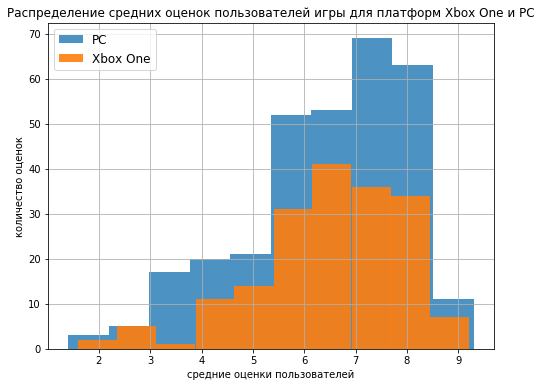

In [73]:
plt.figure(figsize=(8,6))
plt.hist(games_actual.query('platform == "PC"')['user_score'], label='PC', alpha = 0.8)
plt.hist(games_actual.query('platform == "XOne"')['user_score'], label='Xbox One', alpha = 0.9)
plt.xlabel('средние оценки пользователей')
plt.ylabel('количество оценок')
plt.title('Распределение средних оценок пользователей игры для платформ Xbox One и PC')
plt.legend(loc='upper left', fontsize=12)
plt.grid()
plt.show()

Тот же самый эксперимент проведем и для второго вопроса: различаются ли средние пользовательские рейтинги дл жанров *action* и *sports*? Для начала также найдем средние значения и дисперсии данных выборок и сравним их между собой

In [74]:
print('Средняя пользовательская оценка игры в жанре action: {0:.2f}\nДисперсия: {1:.2f}'.\
        format(games_actual.query('genre == "Action"')['user_score'].mean(),
               np.var(games_actual.query('genre == "Action"')['user_score'], ddof=1)))
print('Средняя пользовательская оценка игры в жанре sports: {0:.2f}\nДисперсия: {1:.2f}'.\
        format(games_actual.query('genre == "Sports"')['user_score'].mean(),
               np.var(games_actual.query('genre == "Sports"')['user_score'], ddof=1)))

Средняя пользовательская оценка игры в жанре action: 6.79
Дисперсия: 1.80
Средняя пользовательская оценка игры в жанре sports: 5.65
Дисперсия: 2.88


По первым ощущениям, выборки и их средние значения не очень равны, но доверимся в этом вопросе статистическим методам, а не собственному воображению. Проверяем нулевую гипотезу: *средние значения оценок пользователей для игр из жанра action и sports равны*

In [75]:
results2 = st.ttest_ind(games_actual.query('genre == "Action" and user_score.isna() == False')['user_score'],
                       games_actual.query('genre == "Sports" and user_score.isna() == False')['user_score'], equal_var=False)
alpha = 0.05

print('p-value = {0:.2e}'.format(results2.pvalue))
if results2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value = 4.50e-19
Отвергаем нулевую гипотезу


Полученное значение p-value очень низкое, а значит нулевую гипотезу нам придется отвергнуть

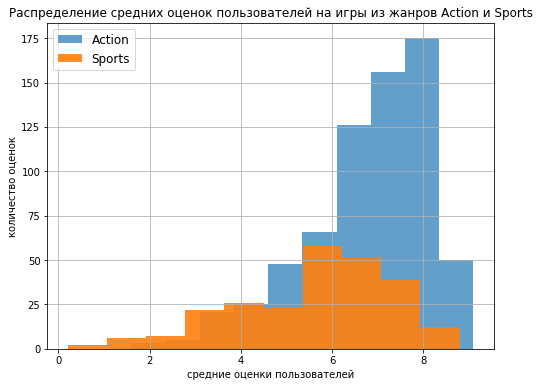

In [76]:
plt.figure(figsize=(8,6))
plt.hist(games_actual.query('genre == "Action"')['user_score'], label='Action', alpha = 0.7)
plt.hist(games_actual.query('genre == "Sports"')['user_score'], label='Sports', alpha = 0.9)
plt.xlabel('средние оценки пользователей')
plt.ylabel('количество оценок')
plt.title('Распределение средних оценок пользователей на игры из жанров Action и Sports')
plt.legend(loc='upper left', fontsize=12)
plt.grid()
plt.show()

Вывод: мы проверили две гипотезы:
* *равны ли средние совокупностей оценок по жанру action и sports: p-value = 4.50e-19, нулевая гипотеза отвергнута;*
* *равны ли средние совокупностей оценок игр для платформ Xbox One и PC: p-value = 0.67, нулевую гипотезу отвергнуть не удалось*

## Вывод

На этапе предобработки данных мы удалили 141 строчки с данными: у 2 из них были пропущены имя и жанр игры, еще у 139 - не удалось установить год выпуска - пропуски в столбцах с возрастным ограничением заменили на *'unknown'*, остальные пропуски в столбцах, требующих численный тип данных, оставили значения *NaN*, так как такие пропуски неслучайные и восстановить их невозможно. Также мы сократили траты на хранение данных почти вдвое, засчет изменения типов данных в столбцах на более эффективные без потери качества и добавили столбец с суммарными показателями по продажам.

На этапе анализа данных мы рассмотрели данные из индустрии игр, выделили последний актуальный период - с 2011-го по 2016-й года - и проанализировали его. Результатом анализа можно назвать следующие выводы:
* самой перспективной платформой для игр на 2017-й год является PS4;
* оценки пользователей не влияют на продажи игр;
* чтобы рассчитывать на многомиллионные продажи необходимо получить высокие оценки от критиков (70 и выше);
* продажи в пяти наиболее популярных жанрах вдвое выше, чем в остальных, а игры из этих жанров занимают 70%-ю долю в индустрии.

Также мы составили портреты пользователей для разных регионов:
* для Северной Америки характерно: платформа - *Xbox 360*, жанр - *action*, возрастное ограничение, равное *13+*;
* для Европы: *Play Station 3*, *action* и также *13+*
* для Японии: *Nintendo 3DS*, *ролевые игры* и не указанный возрастной рейтинг по классификации *ESRB* (возможно, в данной стране действует другая система установления рейтинга играм, которой японцы придерживаются)

В завершении проекта проверили две гипотезы:
* *равны ли средние совокупностей оценок по жанру action и sports: p-value = 4.50e-19 < 0.05 (установленный нами критический уровень значимости), нулевая гипотеза отвергнута;*
* *равны ли средние совокупностей оценок игр для платформ Xbox One и PC: p-value = 0.67 > 0.05, нулевую гипотезу отвергнуть не удалось*